# Autoencoder

In [121]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prep data

In [20]:
raw_data = np.loadtxt("../data/shuffled_data/repeat_shuffle_train.csv", delimiter=",", dtype=float)

In [81]:
raw_data = torch.tensor(raw_data).float() # convert to float32

In [82]:
NN = 10
data = raw_data.T[:,:NN] # take first NN neurons for now
data.shape

torch.Size([226814, 10])

In [83]:
# split into training and validation data
np.random.seed(42)
split = int(0.8 * data.shape[0])
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
train_data = data[indices[:split]]
val_data = data[indices[split:]]

In [24]:
BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

## Define model

In [310]:
def init_weights(layer,fill_bias=0):
    torch.nn.init.constant_(layer.bias, fill_bias)
    torch.nn.init.orthogonal_(layer.weight)

In [311]:
class Encoder(nn.Module):
    def __init__(self, 
                 layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [160,10,2]"):
        super(Encoder, self).__init__()
        
        self.layers = nn.ModuleList([])
        
        for i in range(1,len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            init_weights(self.layers[-1]) 
    
    def forward(self, x):
        for layer in self.layers[:-1]: # encode
            x = F.relu(layer(x))
        x =  self.layers[-1](x)
        return x

In [312]:
class Decoder(nn.Module):
    def __init__(self, 
                layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [2,4,160]"):
        super(Decoder, self).__init__()
        
        self.layers = nn.ModuleList([])
        for i in range(1,len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            init_weights(self.layers[-1])
        
    def forward(self, z):
        for layer in self.layers[:-1]: # decode
            z = F.relu(layer(z))
        z = self.layers[-1](z) # don't apply activation on last layer
        z = torch.sigmoid(z) #squish
        return z

In [313]:
class Autoencoder(nn.Module):
    def __init__(self, encoder_layer_dims, decoder_layer_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(encoder_layer_dims)
        self.decoder = Decoder(decoder_layer_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [314]:
ae = Autoencoder([NNs,4,2],[2,4,NNs])
batch = next(iter(train_data_loader))
reconstruction = ae(batch)
torch.round(reconstruction)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


## Define training loop

In [659]:
def both(x,x_hat):
    return ( (x - x_hat)**2 ).sum() + ( torch.abs(x - x_hat) ).sum()

In [348]:
def eucl(x,x_hat):
    return ( (x - x_hat)**2 ).sum()

In [349]:
def hamming(x,x_hat):
    return ( x*(1-x_hat) + (1-x)*x_hat ).sum()

In [603]:
def train(autoencoder, data, epochs=20, lr=.001, loss_fn=eucl):
    opt = torch.optim.AdamW(autoencoder.parameters(),lr)
    for epoch in range(epochs):
        print(epoch)
        epoch_loss = 0
        for x in tqdm(data):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = eucl(x,x_hat)
            loss.backward()
            opt.step()
            
            epoch_loss += loss
            
        print(f"Train loss: {np.round(epoch_loss.detach().cpu().numpy(),2)}")
        
    return autoencoder

Define model

In [733]:
torch.manual_seed(0)
# define model
NNs = train_data.shape[1]
latent_dims = 3
encoder_layer_dims = [NNs,20,30,20,latent_dims]
decoder_layer_dims = [latent_dims,20,30,20,NNs]
ae = Autoencoder(encoder_layer_dims, decoder_layer_dims).to(device) # GPU

In [734]:
zero_data_loader = torch.utils.data.DataLoader(torch.zeros((100,NNs)), batch_size=BATCH_SIZE)

In [755]:
ae = train(ae,zero_data_loader,100,loss_fn=both)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 448.77it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 484.25it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 703.74it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 546.52it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 720.83it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 611.53it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 899.05it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 960.89it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 743.64it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1080.52it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1130.84it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 898.43it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1161.13it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1228.47it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1057.37it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1057.97it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1182.74it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1208.04it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1016.25it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1096.77it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1193.68it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1157.69it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 831.96it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1101.95it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1202.67it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1028.33it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1139.60it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1180.00it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1160.09it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 863.16it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1148.73it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1173.72it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1176.77it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 923.70it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1127.35it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1123.57it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 974.34it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1032.00it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1172.66it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1147.47it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 940.32it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1123.95it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1217.33it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1010.07it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1224.70it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1185.59it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1208.21it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1022.44it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1106.53it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1210.65it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1187.68it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 967.15it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1118.33it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1204.39it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1256.25it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1083.10it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1189.03it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1199.40it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1188.69it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 996.80it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1198.37it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1177.60it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1071.48it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1222.56it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1077.33it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1265.44it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 952.39it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1281.68it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1258.23it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1145.83it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 933.52it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1123.27it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1154.42it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1012.44it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1099.57it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1144.19it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1176.85it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 935.24it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1108.07it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1173.40it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1135.67it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1034.67it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1204.83it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1194.02it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1221.76it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1068.41it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1179.67it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1165.17it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1001.51it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1176.11it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1234.16it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1198.29it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1055.37it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1147.79it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1204.74it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1165.49it/s]


Train loss: 0.0


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 995.21it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1150.70it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1163.07it/s]


Train loss: 0.0


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1259.08it/s]

Train loss: 0.0


In [769]:
ae = train(ae,train_data_loader,10,loss_fn=both,lr=0.001)

100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2013.79it/s]


Train loss: 3970.5400390625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2047.75it/s]


Train loss: 3221.68994140625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2042.79it/s]


Train loss: 2778.280029296875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2046.93it/s]


Train loss: 2404.169921875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2044.65it/s]


Train loss: 2317.340087890625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2036.15it/s]


Train loss: 2157.77001953125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2037.97it/s]


Train loss: 2061.89990234375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2027.83it/s]


Train loss: 2014.3800048828125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2006.87it/s]


Train loss: 1976.02001953125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2025.15it/s]

Train loss: 1873.300048828125


## Visualise latent representations

In [770]:
def plot_latent(autoencoder, data):
    """
        Plots the latent representation of states, colouring states by how many neurons fire
        data should be a SxN tensor where S is the number of states and N the number of neurons
    """
    Ks = data.sum(axis=1).detach().numpy() #how many neurons fired in each state
    z = ae.encoder(data).detach().numpy() #SxL where L is the latent dimensions
    cmap = plt.get_cmap('RdBu', np.max(Ks)-np.min(Ks)+1)
    plt.scatter(z[:,0],z[:,1],c=Ks,marker=".",cmap=cmap)
    plt.colorbar()

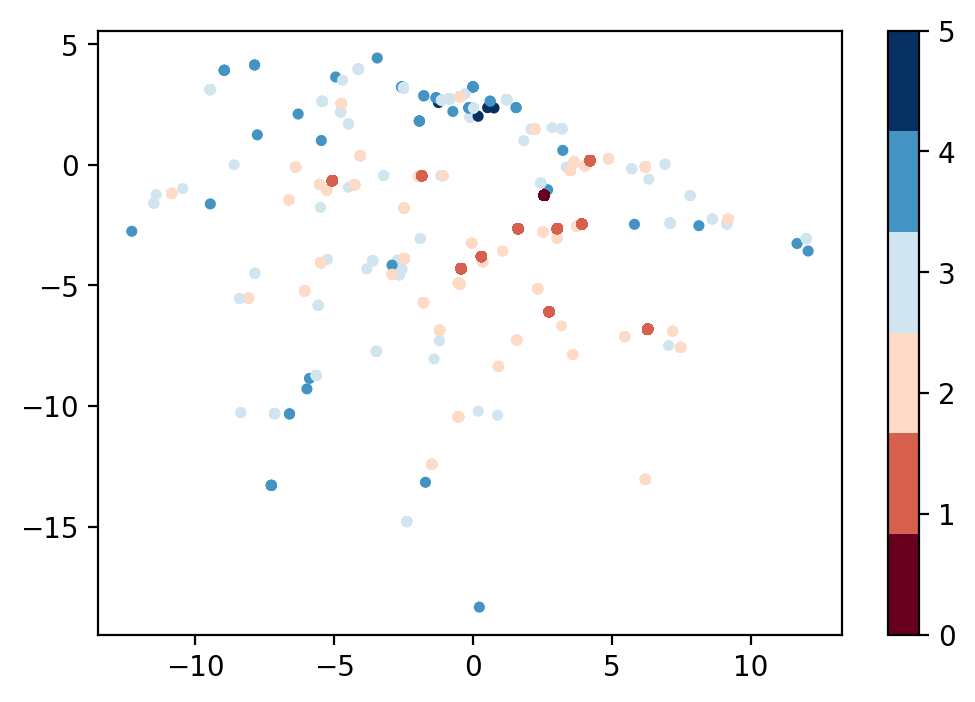

In [771]:
plot_latent(ae, val_data)

In [772]:
recon = ae(val_data)

In [773]:
Ks = val_data.sum(axis=1)

In [774]:
def hamming(data, recon):
    XORS = data * (1-recon) + (1-data) * recon
    return XORS.sum(1)

In [775]:
print("Hamming distances")
print("%2s %5s %4s %4s" % ("K", "obvs", "mean", "max"))

for K in range(int(torch.max(Ks))+1):
    states_K_fire = val_data[Ks==K]
    recon = torch.round(ae(states_K_fire))
    ham_dists = hamming(states_K_fire,recon)
    N_samples = states_K_fire.shape[0]
    print("%2s %5s %.2f %3s" % (K, N_samples, float(torch.mean(ham_dists)), int(torch.max(ham_dists)) ))
    

Hamming distances
 K  obvs mean  max
 0 35913 0.00   0
 1  7503 0.00   0
 2  1535 0.15   1
 3   346 0.44   2
 4    62 1.06   4
 5     4 2.25   4


In [776]:
states_K_fire = val_data[Ks==5]
recons = torch.round(ae(states_K_fire))
for state, recon in zip(states_K_fire, recons):
    print(state.numpy())
    print(recon.detach().numpy())
    print("----")

[0. 1. 1. 0. 1. 1. 0. 1. 0. 0.]
[0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
----
[0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
[0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
----
[1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
[1. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
----
[0. 1. 0. 0. 1. 1. 0. 1. 0. 1.]
[0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
----
